# Sub Donors

The goal here is to determine total number of subscriber households, subscriber households who donated, and total donation amount by subscribers who donated.

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Imports

In [2]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%matplotlib inline

In [3]:
os.chdir('/projects/customer/')

## User Inputs

In [4]:
first_day_of_first_fy = dt.datetime(2009, 7, 1)
last_day_of_last_fy = dt.datetime(2019, 6, 30)

## Import Data

Path from cwd to raw data files

In [5]:
path = "data/raw/"

Functions for data imports

In [6]:
def subscriber_data_import(series, fy_start=10, fy_end=19, path=path + 'subs/'):
    """
    This function retrieves all of the subscription files across a\
 user determined date range and series. 
    
    Keyword arguments:
    series -- either 'clx' or 'pops'
    fy_start -- earliest fiscal year in question (default 10)
    fy_end -- last fiscal year in question (default 19)
    path -- path to data (default 'data/raw/subs/')
    
    Returns:
    df -- pandas dataframe consisting of
    """
    
    accepted_series = ['clx', 'pops']
    
    if series.lower() not in accepted_series:
        raise ValueError('series must be of accepted series types: ', 
                         accepted_series)
    
    dataframes = []
    for i in range(fy_start, fy_end+1):
        file = f"FY{i}-{series.capitalize()}.csv"
        tmp = pd.read_csv(path + file, encoding="ISO-8859-1")
        tmp['fy'] = i
        dataframes.append(tmp)

    df = pd.concat(dataframes, ignore_index=True)
    
    return df

In [7]:
def donor_data_import(path=path):
    donor_raw = pd.read_csv(path + "donors_fy08-present.csv", encoding='ISO-8859-1')
    return donor_raw

Import the data

In [8]:
donor_copy = donor_data_import()

C:\Users\bkessler\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3214: DtypeWarning: Columns (81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [9]:
subs_clx = subscriber_data_import(series='clx')
subs_pops = subscriber_data_import(series='pops')

## Format Data

#### Donor Data

In [10]:
donor_fy = donor_copy.campaign.str[3:8] # parse last 5 characters of campaign column
donor_copy['fy'] = donor_fy # append that to a column named 'fy'

Identify which 'fys' don't start with an integer, these we can remove. Also, identify the years that are outside of the range in question

In [11]:
filter_fys = {fy: False for fy in donor_copy.fy.drop_duplicates()}
for fy,boo in filter_fys.items():
    try:
        int(fy[0])
        if (int(fy[3:]) > 9) & (int(fy[3:]) < 20):
            filter_fys[fy] = True
        else:
            continue
    except:
        continue

Map the fy column to identify rows to remove then remove them

In [12]:
donor_copy['keep'] = donor_copy['fy'].map(filter_fys)
donor_df = donor_copy.loc[donor_copy.keep].reset_index()
donor_df.drop(columns=['keep'], inplace=True)

Remove unnecessary columns

In [13]:
donor_cols = ['summary_cust_id', 'gift_plus_pledge', 'fy']
donor_df = donor_df[donor_cols]

Strip FY to only include the last two digits of fiscal year

In [14]:
donor_df['fy'] = donor_df['fy'].str[3:]

Aggregate donor by fiscal year

In [15]:
donor_df_aggregate = donor_df.groupby(['summary_cust_id', 'fy']).sum().reset_index()

In [16]:
donor_df_aggregate['fy'] = np.int64(donor_df_aggregate['fy'])

#### Subscriber Data

In [17]:
sub_cols = ['summary_cust_id', 'fy']
subs_clx = subs_clx[sub_cols]
subs_pops = subs_pops[sub_cols]

In [18]:
subs_clx = subs_clx.drop_duplicates()
subs_pops = subs_pops.drop_duplicates()

In [19]:
print(subs_clx.shape, subs_pops.shape)

(13471, 2) (8723, 2)


## Merge Data

In [20]:
clx_merge = pd.merge(subs_clx, donor_df_aggregate, on=['summary_cust_id', 'fy'], how='left')
pops_merge = pd.merge(subs_pops, donor_df_aggregate, on=['summary_cust_id', 'fy'], how='left')

In [21]:
clx_merge.fillna(0, inplace=True)
pops_merge.fillna(0, inplace=True)

In [22]:
clx_merge.head()

,summary_cust_id,fy,gift_plus_pledge
0,419478,10,0.0
1,419813,10,300.0
2,420202,10,100.0
3,420535,10,0.0
4,420635,10,304.0


In [23]:
def sub_donor_analysis(df):
    """
    This function aggregates total subs, total subs that donate,\
 and total donations from a dataframe. 
    
    Keyword arguments:
    df -- must contain three columns:
        1) summary_cust_id
        2) fy
        3) gift_plus_pledge
    
    Returns:
    dictionary -- a dictionary containing each fiscal year with the\
 below structure per fiscal year:
 
    {
        fy: {
            total_subs: <int>,
            total_subs_donating: <int>,
            percent_donating: <percent>,
            total_given_by_subs: <int>
        }
    }
    """
    
    stats = {
        'total_subs': 0,
        'total_subs_donating': 0,
        'percent_donating': 0,
        'total_given_by_subs': 0
    }
    
    init_dict = {fy:stats.copy() for fy in clx_merge['fy'].drop_duplicates()}
    
    for row in df.iterrows():
        fy = row[1]['fy']
        gift = row[1]['gift_plus_pledge']
                
        init_dict[int(fy)]['total_subs'] += 1
        
        if gift > 0:
            init_dict[int(fy)]['total_subs_donating'] += 1
            init_dict[int(fy)]['total_given_by_subs'] += gift

    
    for k,v in init_dict.items():
        v['percent_donating'] = v['total_subs_donating'] / v['total_subs']
        v['percent_donating'] = v['percent_donating']
        v['total_given_by_subs'] = v['total_given_by_subs']
    
    return init_dict

In [24]:
clx = pd.DataFrame(sub_donor_analysis(clx_merge))
pops = pd.DataFrame(sub_donor_analysis(pops_merge))

In [25]:
pops

,10,11,12,13,14,15,16,17,18,19
percent_donating,3.492823e-01,3.936270e-01,3.562316e-01,3.690112e-01,4.059977e-01,3.944444e-01,4.554745e-01,4.582133e-01,3.926554e-01,3.269231e-01
total_given_by_subs,1.706234e+06,2.142963e+06,2.103987e+06,2.499788e+06,2.691359e+06,1.947365e+06,1.676091e+06,1.793689e+06,2.235750e+06,1.621559e+06
total_subs,1.254000e+03,1.067000e+03,1.019000e+03,9.810000e+02,8.670000e+02,7.200000e+02,6.850000e+02,6.940000e+02,7.080000e+02,7.280000e+02
total_subs_donating,4.380000e+02,4.200000e+02,3.630000e+02,3.620000e+02,3.520000e+02,2.840000e+02,3.120000e+02,3.180000e+02,2.780000e+02,2.380000e+02


In [26]:
clx

,10,11,12,13,14,15,16,17,18,19
percent_donating,4.761905e-01,4.790334e-01,4.311864e-01,4.595258e-01,4.711033e-01,4.780764e-01,4.865248e-01,5.125554e-01,4.888535e-01,4.113636e-01
total_given_by_subs,3.864624e+06,4.351452e+06,4.243744e+06,4.167281e+06,5.612578e+06,6.032157e+06,5.332457e+06,5.655178e+06,5.678521e+06,4.930356e+06
total_subs,1.470000e+03,1.407000e+03,1.475000e+03,1.223000e+03,1.142000e+03,1.414000e+03,1.410000e+03,1.354000e+03,1.256000e+03,1.320000e+03
total_subs_donating,7.000000e+02,6.740000e+02,6.360000e+02,5.620000e+02,5.380000e+02,6.760000e+02,6.860000e+02,6.940000e+02,6.140000e+02,5.430000e+02


## Plotting Classics

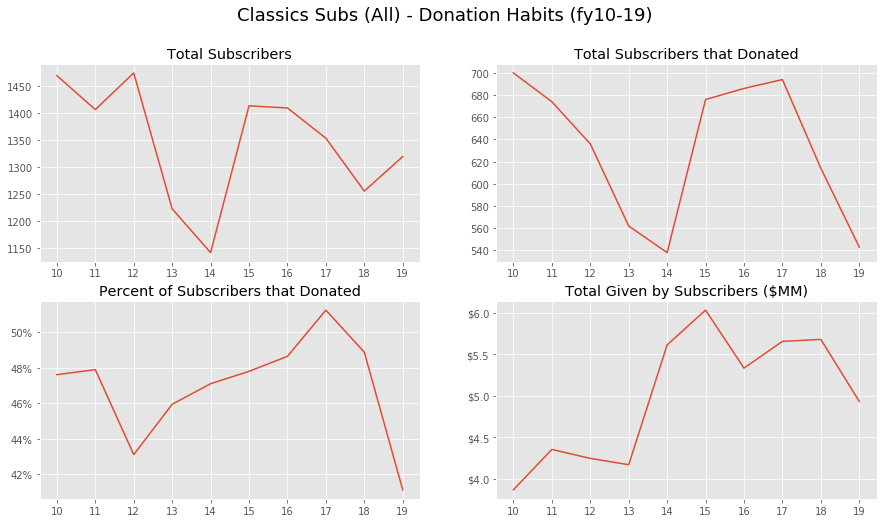

In [71]:
# Plot setup
plt.style.use('ggplot')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

fig.suptitle('Classics Subs (All) - Donation Habits (fy10-19)', fontsize=18)

# Plotting data
ax1.plot(clx.columns, clx.loc['total_subs'])
ax2.plot(clx.columns, clx.loc['total_subs_donating'])
ax3.plot(clx.columns, clx.loc['percent_donating'])
ax4.plot(clx.columns, [x/1000000 for x in clx.loc['total_given_by_subs']])

ax1.set_title('Total Subscribers')
ax2.set_title('Total Subscribers that Donated')
ax3.set_title('Percent of Subscribers that Donated')
ax4.set_title('Total Given by Subscribers ($MM)')

# Setting tick values
ax1.set_xticks(clx.columns)
ax2.set_xticks(clx.columns)
ax3.set_xticks(clx.columns)
ax4.set_xticks(clx.columns)

# Formatting axes ticks
ax3_vals = ax3.get_yticks()
ax3.set_yticklabels(["{:.0%}".format(x) for x in ax3_vals])

ax4_vals = ax4.get_yticks()
ax4.set_yticklabels(["${:,.1f}".format(x) for x in ax4_vals])

# Plotting formatting
plt.show()

## Plotting Pops

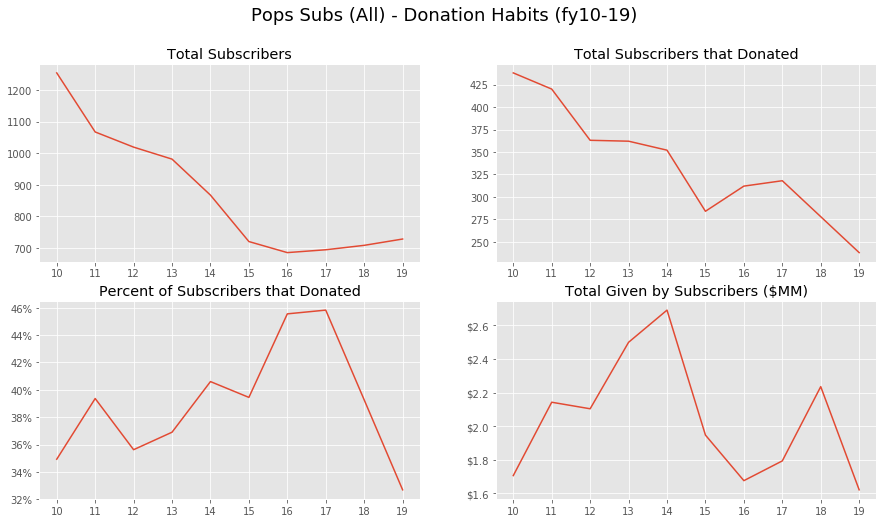

In [70]:
# Plot setup
plt.style.use('ggplot')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

fig.suptitle('Pops Subs (All) - Donation Habits (fy10-19)', fontsize=18)

# Plotting data
ax1.plot(pops.columns, pops.loc['total_subs'])
ax2.plot(pops.columns, pops.loc['total_subs_donating'])
ax3.plot(pops.columns, pops.loc['percent_donating'])
ax4.plot(pops.columns, [x/1000000 for x in pops.loc['total_given_by_subs']])

ax1.set_title('Total Subscribers')
ax2.set_title('Total Subscribers that Donated')
ax3.set_title('Percent of Subscribers that Donated')
ax4.set_title('Total Given by Subscribers ($MM)')

# Setting tick values
ax1.set_xticks(pops.columns)
ax2.set_xticks(pops.columns)
ax3.set_xticks(pops.columns)
ax4.set_xticks(pops.columns)

# Formatting axes ticks
ax3_vals = ax3.get_yticks()
ax3.set_yticklabels(["{:.0%}".format(x) for x in ax3_vals])

ax4_vals = ax4.get_yticks()
ax4.set_yticklabels(["${:,.1f}".format(x) for x in ax4_vals])

# Plotting formatting
plt.show()

## Write dfs to excel

In [73]:
with pd.ExcelWriter('sub_donor_habits.xlsx') as writer:
    clx.to_excel(writer, sheet_name='Classics')
    pops.to_excel(writer, sheet_name='Pops')